**Partie I**

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# les arrays sont batis avec les dimensions suivantes:
# pluie, arroseur, watson, holmes
# et chaque dimension: faux, vrai

prob_pluie = np.array([0.8, 0.2]).reshape(2, 1, 1, 1)
print ("Pr(Pluie)={}\n".format(np.squeeze(prob_pluie[1,:,:,:])))
prob_arroseur = np.array([0.9, 0.1]).reshape(1, 2, 1, 1)
print ("Pr(Arroseur)={}\n".format(np.squeeze(prob_arroseur[:,1,:,:])))
watson = np.array([[0.8, 0.2], [0, 1]]).reshape(2, 1, 2, 1)
print ("Pr(Watson|Pluie)={}\n".format(np.squeeze(watson[1,:,1,:])))
holmes = np.array([[1,0], [0.1,0.9], [0,1], [0,1]]).reshape(2,2,1,2)
print ("Pr(Holmes|Pluie,arroseur)={}\n".format(np.squeeze(holmes[1,1,:,1])))
print("---")

print("A: P(H=1) =",(holmes * prob_pluie * prob_arroseur * watson)[:,:,:,1].sum())

print("\nB: P(H=1|W=1) =", (holmes * prob_pluie * prob_arroseur * watson)[:,:,1,1].sum()/(holmes * prob_pluie * prob_arroseur * watson)[:,:,1,:].sum())

print("\nC: P(H=1|W=0) =", (holmes * prob_pluie * prob_arroseur * watson)[:,:,0,1].sum()/(holmes * prob_pluie * prob_arroseur * watson)[:,:,0,:].sum())

print("\nD: P(H=1|P=0,W=1) =", (holmes * prob_pluie * prob_arroseur * watson)[0,:,1,1].sum()/(holmes * prob_pluie * prob_arroseur * watson)[0,:,1,:].sum())

print("\nE: P(W=1|H=1) =", (holmes * prob_pluie * prob_arroseur * watson)[:,:,1,1].sum()/(holmes * prob_pluie * prob_arroseur * watson)[:,:,:,1].sum())

print("\nF: P(W=1|H=1,A=1) =", (holmes * prob_pluie * prob_arroseur * watson)[:,:,1,:].sum())

Pr(Pluie)=0.2

Pr(Arroseur)=0.1

Pr(Watson|Pluie)=1.0

Pr(Holmes|Pluie,arroseur)=1.0

---
A: P(H=1) = 0.272

B: P(H=1|W=1) = 0.5955555555555556

C: P(H=1|W=0) = 0.09

D: P(H=1|P=0,W=1) = 0.09000000000000001

E: P(W=1|H=1) = 0.7882352941176471

F: P(W=1|H=1,A=1) = 0.36000000000000004


**Partie II**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

X = digits.data

y = digits.target
y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
y_one_hot[np.arange(y.shape[0]), y] = 1  # one hot target or shape NxK

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


nb_epochs = 50


def softmax(x):
    # assurez vous que la fonction est numeriquement stable
    # e.g. softmax(np.array([1000, 10000, 100000], ndim=2))
    exp = np.exp(x - x.max(0))
    return np.array(exp / exp.sum(0))


def get_accuracy(X, y, W):
    correct = 0
    P = np.array(softmax(W @ X.T)).T
    for i in range(len(P)):
        if np.argmax(P[i]) == np.argmax(y[i]):
            correct += 1
    return correct / len(X)


def get_grads(y, y_pred, x):
    return - x.T @ (y - y_pred.T) / x.shape[0]


def get_loss(y, y_pred):
    return np.nanmean(-y * np.log(y_pred))


def classifier(lr=0.001, minibatch=20, adam=False, graph=False):
    W = np.random.normal(0, 0.01, (len(np.unique(y)), X.shape[1]))  # weights of shape KxL
    losses_validation = []
    losses_train = []
    best_W = None
    best_accuracy = 0
    accuracies = []
    y_pred = []
    B1 = 0.9
    B2 = 0.999
    epsilon = 10 ** -8
    

    minibatch_size = len(y) // minibatch
    for epoch in range(nb_epochs):
        permutaion = list(np.random.permutation(X_train.shape[0]))
        X_shuffle = X_train[permutaion]
        y_shuffle = y_train[permutaion]
        m = 0
        v = 0
        t = 0

        for i in range(0, X_shuffle.shape[0], minibatch_size):
            x = X_shuffle[i:i + minibatch_size]
            y_pred_batch = softmax(W @ x.T)
            G = get_grads(y_shuffle[i:i + minibatch_size], y_pred_batch, x)
            if adam:
                t+=1
                m = B1 * m + (1 - B1) * G.T
                v = B2 * v + (1 - B2) * G.T ** 2
                m2 = m / (1 - B1**t)
                v2 = v / (1 - B2**t)
                W = W - lr * m2 / (np.sqrt(v2) + epsilon)
            else:
                W -= G.T * lr


        P_train = softmax(W @ X_train.T)
        losses_train.append(get_loss(y_train, P_train.T))

        P_validation = softmax(W @ X_validation.T)
        losses_validation.append(get_loss(y_validation, P_validation.T))  # compute the loss on the train set

        y_pred.append(P_validation)

        accuracy = get_accuracy(X_validation, y_validation, W)
        accuracies.append(accuracy)  # compute the accuracy on the validation set
        if accuracy > best_accuracy:
            best_accuracy = accuracy  # select the best parameters based on the validation accuracy
            best_W = W

    accuracy_on_unseen_data = get_accuracy(X_test, y_test, best_W)
    print(accuracy_on_unseen_data)  # 0.897506925208

    plt.plot(losses_train, label="train (batch: %d, lr: %0.3f)"%(minibatch,lr))
    plt.plot(losses_validation, label="validation (acc: %0.3f, adam=%s)"%(accuracy_on_unseen_data, str(adam)))
    plt.legend()
    plt.ylabel("log de vraisemblance negative moyenne")
    plt.xlabel("Epoch")
    plt.show()

    if graph:
        plt.imshow(best_W[5, :].reshape(8, 8))
        plt.show()


0.9518518518518518


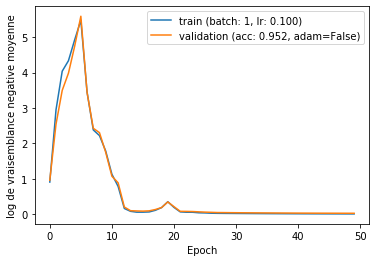

0.9629629629629629


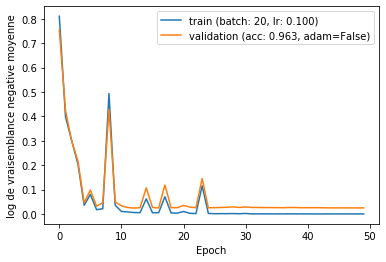

0.9629629629629629


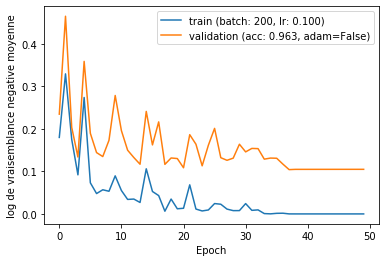

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


0.9629629629629629


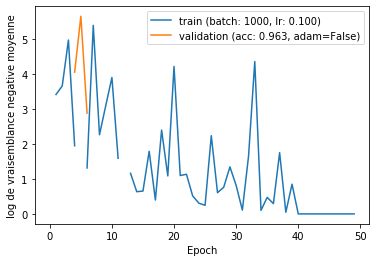

0.9333333333333333


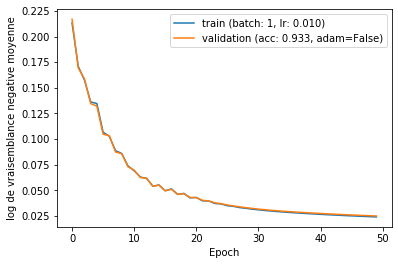

0.9592592592592593


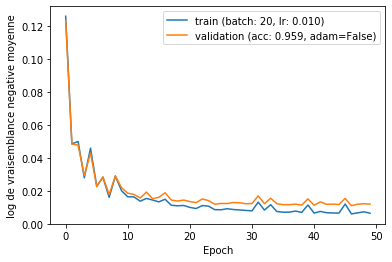

0.9629629629629629


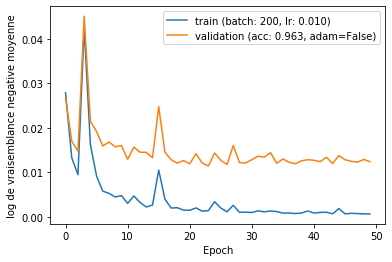

0.9666666666666667


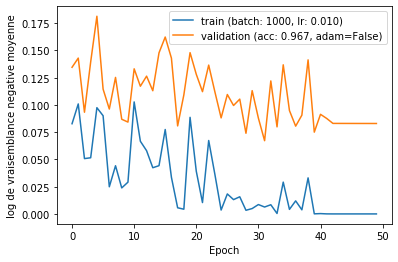

0.9111111111111111


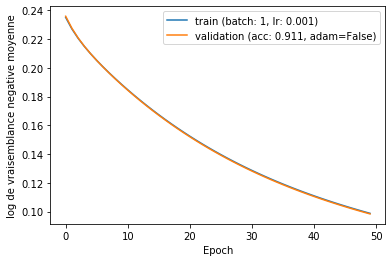

0.9481481481481482


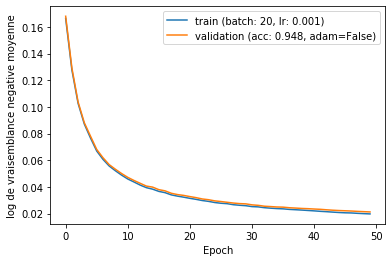

0.9703703703703703


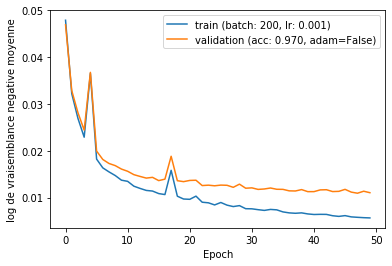

0.9666666666666667


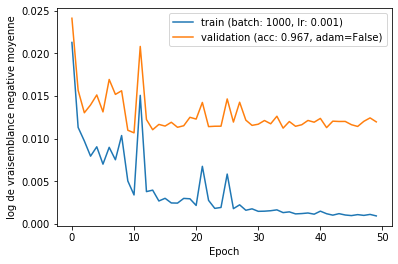

In [6]:
lr = [0.1, 0.01, 0.001]
minibatch = [1, 20, 200, 1000]
for l in lr:
    for b in minibatch:
        classifier(l, b)

0.8962962962962963


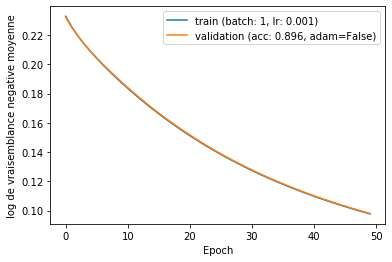

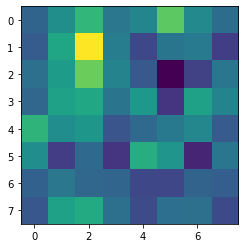

0.9481481481481482


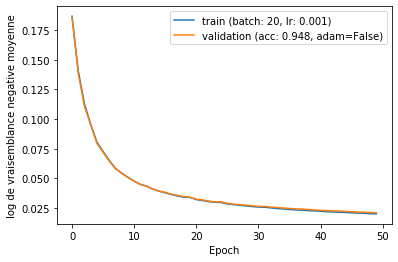

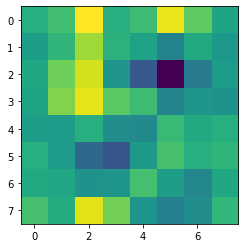

0.9777777777777777


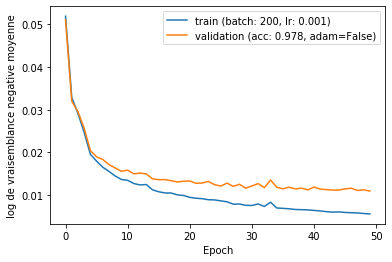

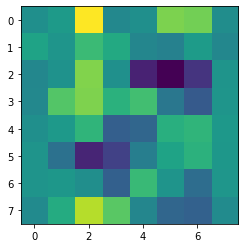

0.9629629629629629


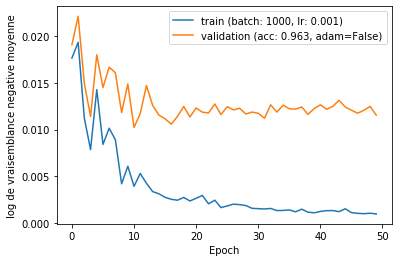

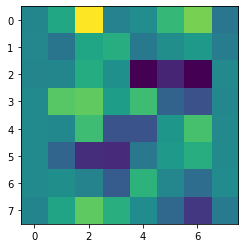

0.9074074074074074


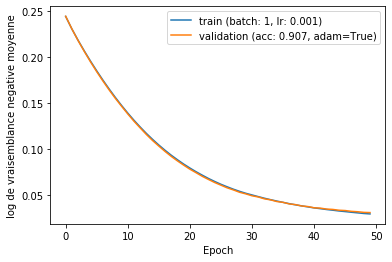

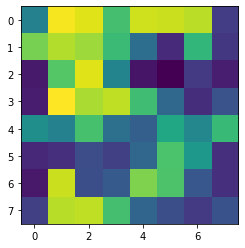

0.9629629629629629


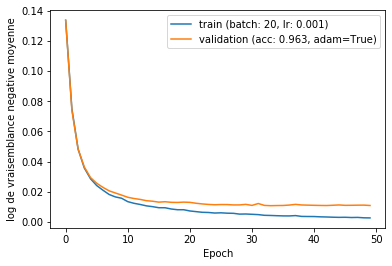

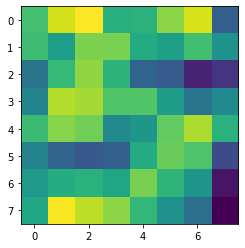

0.9666666666666667


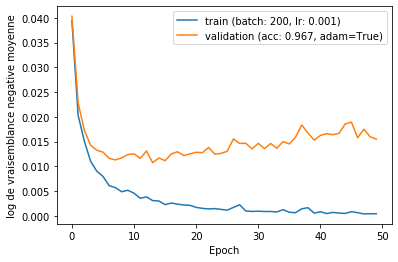

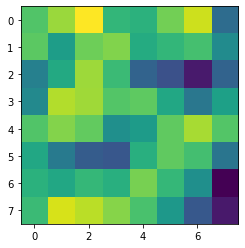

0.9555555555555556


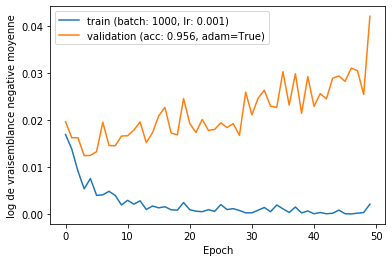

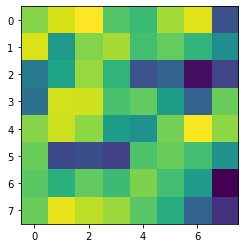

In [8]:
classifier(0.001, 1, False, True)
classifier(0.001, 20, False, True)
classifier(0.001, 200, False, True)
classifier(0.001, 1000, False, True)
classifier(0.001, 1, True, True)
classifier(0.001, 20, True, True)
classifier(0.001, 200, True, True)
classifier(0.001, 1000, True, True)